In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_dataset import load_titanic
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from util.utils import learning_curve_with_cross_validation
from util.utils import perform_grid_search
from util.utils import best_model_test_set_metrics 
from sklearn.tree import plot_tree
from tqdm import tqdm


# fix all random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
df = load_titanic()
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=df['target'])
X = df.drop('target', axis=1)
y = df['target']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=df.drop('target', axis=1).columns)


X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)



# compute the weight dict for future use
weight_dict = df['target'].value_counts().to_dict()
weight_dict[0] = weight_dict[0] / weight_dict[1]
weight_dict[1] = 1.0

%load_ext autoreload
%autoreload 2

In [2]:
# standard scale pclass,age, sibsp, parch, fare

X_numerical = X[['pclass', 'age', 'sibsp', 'parch', 'fare']]
X_categorical = X.drop(['pclass', 'age', 'sibsp', 'parch', 'fare'], axis=1)

X_numerical = scaler.fit_transform(X_numerical)
X_numerical = pd.DataFrame(X_numerical, columns=['pclass', 'age', 'sibsp', 'parch', 'fare'])

X_scaled = pd.concat([X_numerical, X_categorical], axis=1)
X_scaled

,pclass,age,sibsp,parch,fare,alone,adult,Cherbourg,Queenstown,Southampton,female,male
0,0.908600,-0.527669,0.522511,-0.506787,-0.516380,0,1,0,0,1,0,1
1,-1.482983,0.577094,0.522511,-0.506787,0.694046,0,1,1,0,0,1,0
2,0.908600,-0.251478,-0.552714,-0.506787,-0.503620,1,1,0,0,1,1,0
3,-1.482983,0.369951,0.522511,-0.506787,0.350326,0,1,0,0,1,1,0
4,0.908600,0.369951,-0.552714,-0.506787,-0.501257,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.908600,0.646142,-0.552714,5.350885,-0.102875,0,1,0,1,0,1,0
708,-0.287191,-0.182430,-0.552714,-0.506787,-0.407687,1,1,0,0,1,0,1
709,-1.482983,-0.734812,-0.552714,-0.506787,-0.086335,1,1,0,0,1,1,0
710,-1.482983,-0.251478,-0.552714,-0.506787,-0.086335,1,1,1,0,0,0,1


# 1. Clustering algorithms

In [3]:
# Let's apply clustering on the dataset: Expectation Maximization and KMeans

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## 1.1 Dendrogram
Helps to visualize the clustering of the data. It is a tree-like diagram that records the sequences of merges or splits.

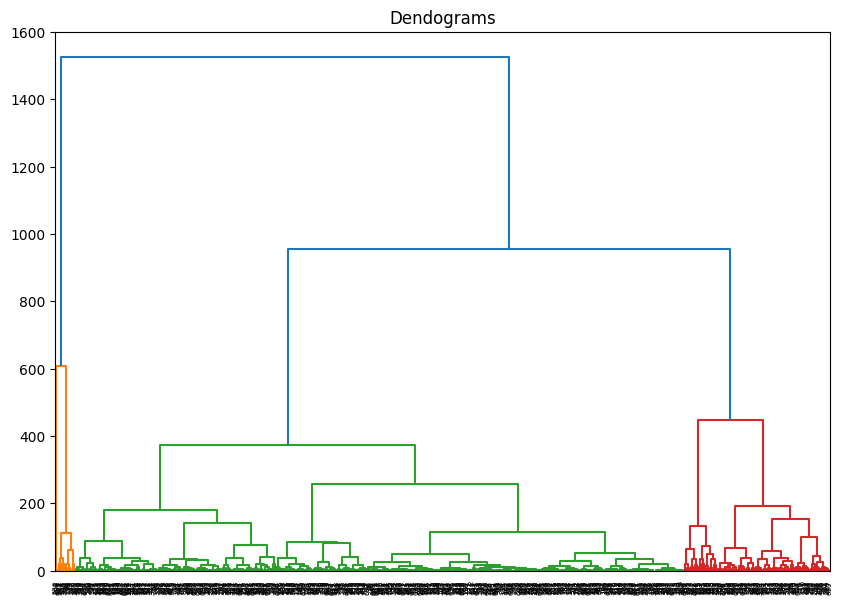

In [5]:
# first apply agglomerative clustering, visualize the hierarchy and then apply kmeans
from sklearn.cluster import AgglomerativeClustering
# visualize dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'), color_threshold=750)

## 1.2 Clustering with K-Medoids

In [89]:
from util.utils import k_medoid_multi_seed

# apply k-medoids clustering
k_medoids = k_medoid_multi_seed(X_scaled, 2, 30, metric='cosine')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:03<00:00,  8.52it/s]


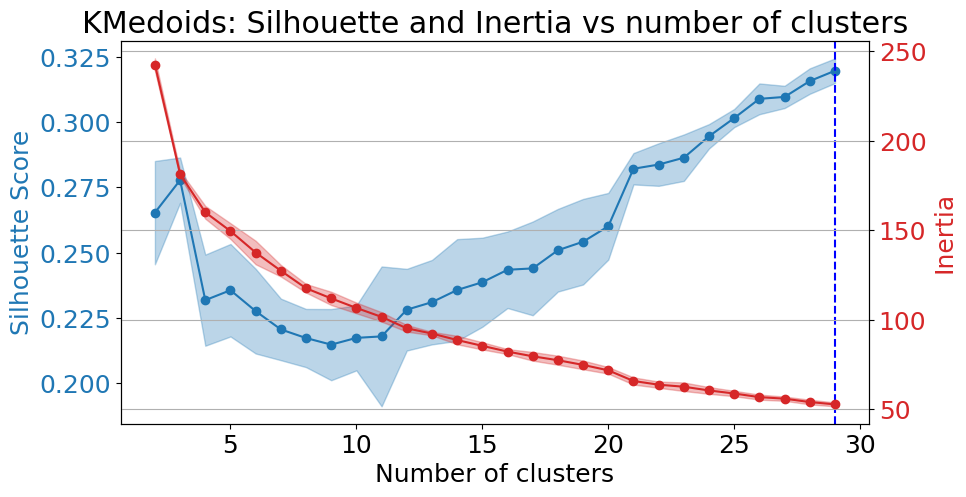

In [90]:
from util.utils import plot_k_medoid_multi_seed

plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[2], k_medoids[3])

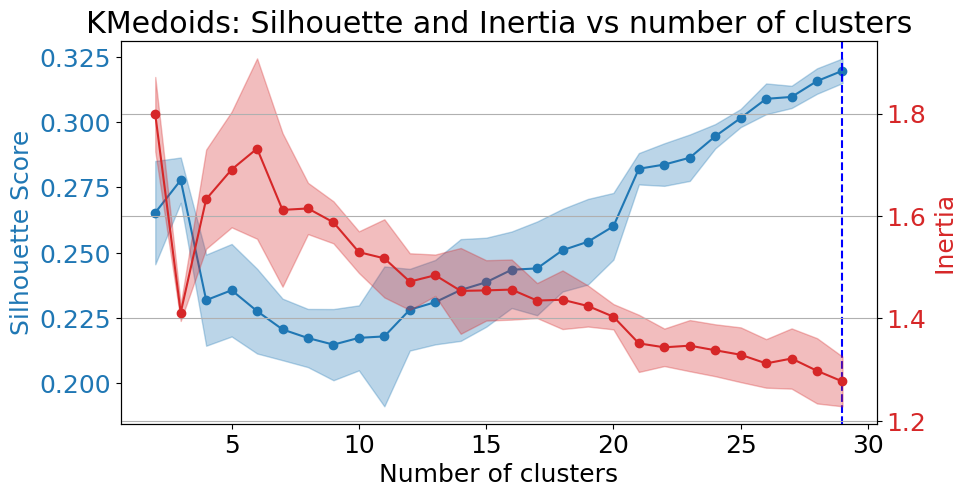

In [91]:
plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[4], k_medoids[5])

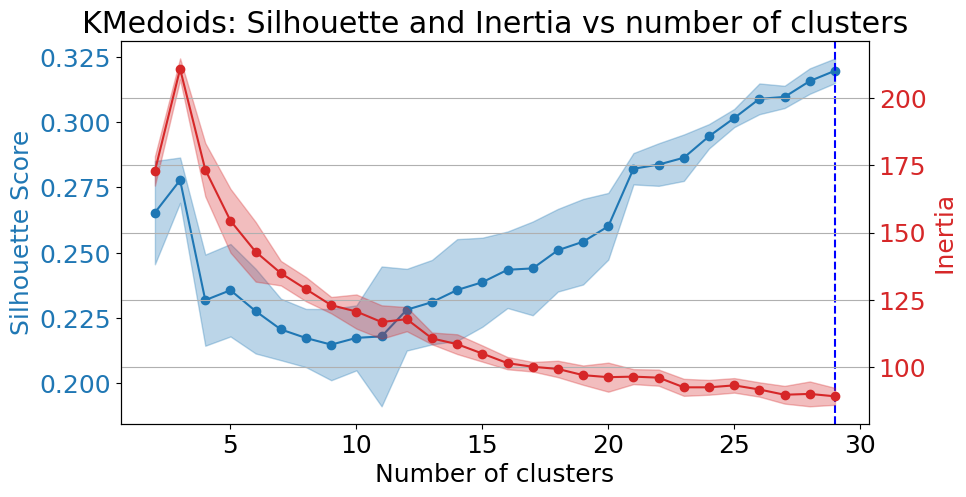

In [92]:
plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[6], k_medoids[7])

In [110]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='cosine')
kmedoids.fit(X_scaled)
kmedoids_labels = kmedoids.predict(X_scaled)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.18651092788233603


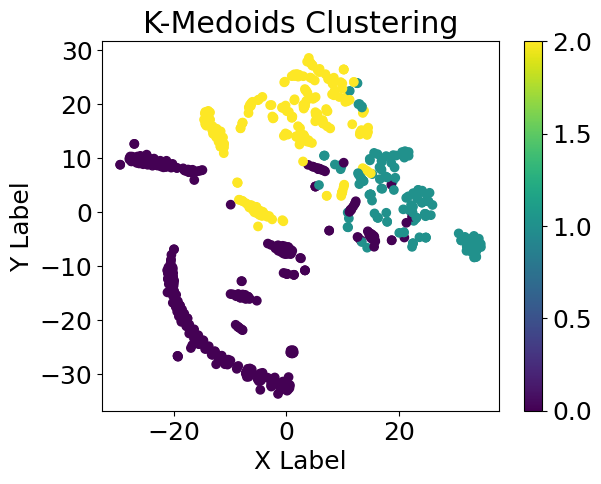

In [111]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

X_tsne = tsne.fit_transform(X_scaled)

# 3d plot
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=kmedoids_labels, s=50)
# ax.set_title('K-Medoids Clustering')
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.colorbar(scatter)
# plt.show()

# 2d plot
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmedoids_labels, cmap='viridis')
plt.title('K-Medoids Clustering')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.colorbar()
plt.show()

## 1.2 EM algorithm

In [165]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_metrics = gaussian_mixture_multi_seed(X, k_min=2, k_max=10, covariance_type='tied')

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


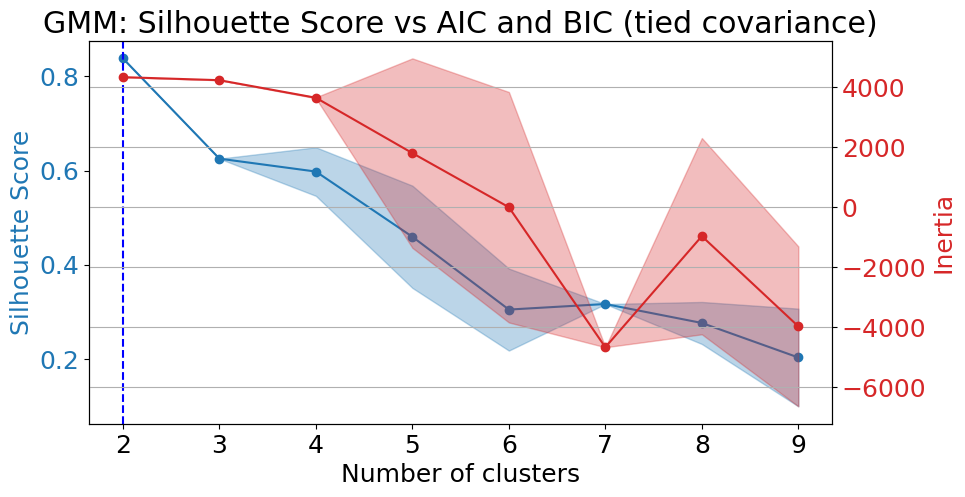

In [166]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 10, gmm_metrics[0], gmm_metrics[1], gmm_metrics[2], gmm_metrics[3], gmm_metrics[4], gmm_metrics[5], covariance_type='tied')

In [168]:
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7, covariance_type='tied', random_state=RANDOM_SEED)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)
ari = adjusted_rand_score(gmm_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.08474080914288173


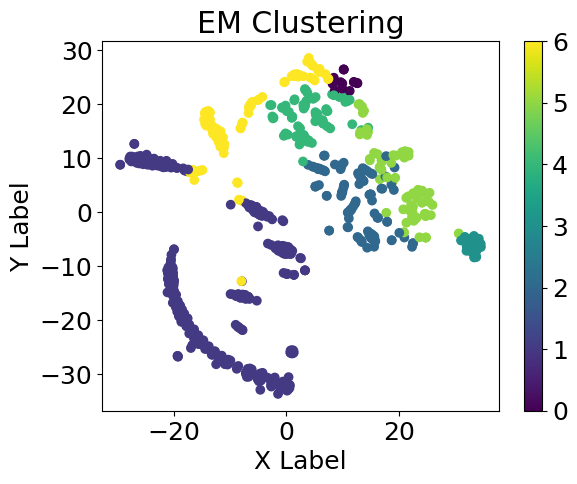

In [169]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=gmm_labels, cmap='viridis')
plt.title('EM Clustering')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.colorbar()
plt.show()

# 2. Dimensionality reduction algorithms

## 2.1 PCA

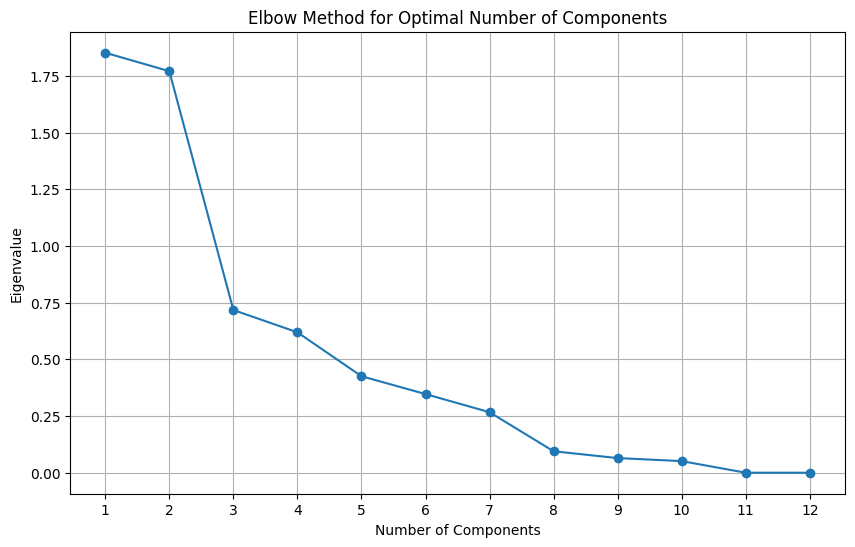

In [5]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=12, random_state=RANDOM_SEED)

# Fit PCA on the scaled training data
pca.fit(X_scaled)

# Get eigenvalues
eigenvalues = pca.explained_variance_

plt.figure(figsize=(10, 6))
# Plot eigenvalues to visualize the explained variance
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.title('Elbow Method for Optimal Number of Components')
# Add a gridd to the plot
plt.grid()
# x axis ticks to be integers
plt.xticks(range(1, len(eigenvalues)+1))
plt.show()

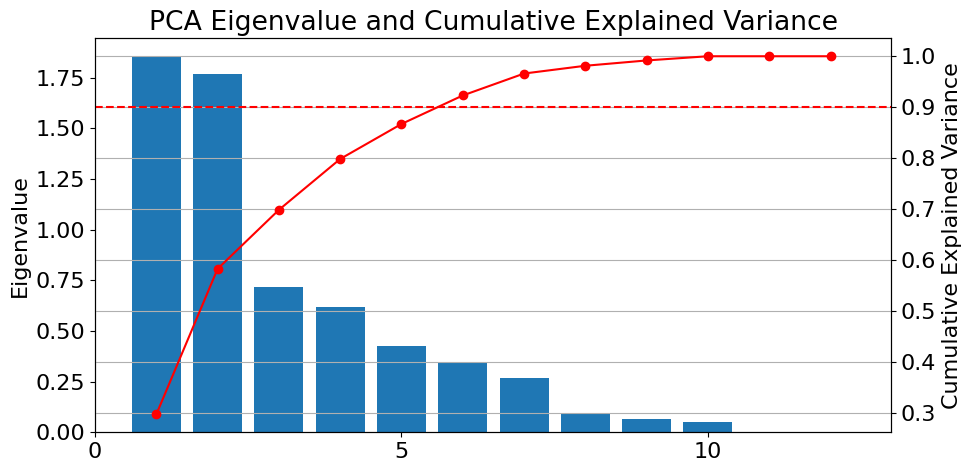

In [8]:
from util.utils import plot_pca_eigen_and_variance

pca = PCA(n_components=12, random_state=RANDOM_SEED)

plot_pca_eigen_and_variance(X_scaled, pca, dataset_name="Titanic", ratio_threshold=0.90)

### 2.1.2 Step 2: Validate the data with Visualization and Simple Classifier


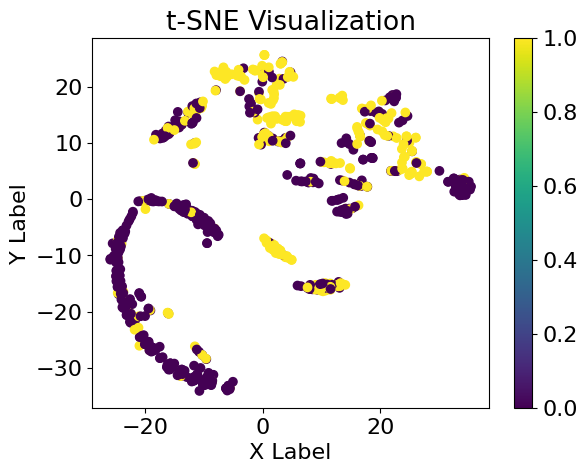

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# X_tsne = tsne.fit_transform(X_scaled)

# plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis')
# plt.title('t-SNE Visualization')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.colorbar()
# plt.show()
pca = PCA(n_components=5, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)
X_tsne_pca = tsne.fit_transform(X_pca)

plt.scatter(X_tsne_pca[:,0], X_tsne_pca[:,1], c=y, cmap='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.colorbar()
plt.show()



In [18]:
from sklearn.tree import DecisionTreeClassifier 

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        85
           1       0.63      0.71      0.67        58

    accuracy                           0.71       143
   macro avg       0.71      0.71      0.71       143
weighted avg       0.72      0.71      0.72       143

Accuracy: 0.7132867132867133
F1 Score: 0.7152888011783718


In [19]:
from sklearn.tree import DecisionTreeClassifier 

# split X_pca into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80        85
           1       0.70      0.72      0.71        58

    accuracy                           0.76       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.76      0.76      0.76       143

Accuracy: 0.7622377622377622
F1 Score: 0.7628374450408348


## 2.2 ICA

  0%|          | 0/58 [00:00<?, ?it/s]

  3%|▎         | 2/58 [00:00<00:05,  9.76it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 36%|███▌      | 21/58 [00:01<00:02, 14.46it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 40%|███▉      | 23/58 [00:01<00:04,  7.64it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing toleranc

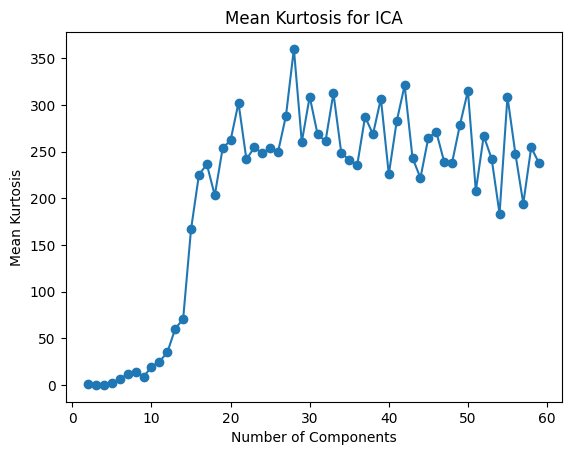

In [83]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# loop through different number of components and compute mean kurtosis
kurtosis_ = []
n_components = range(2, 60)

for n in tqdm(n_components):
    ica = FastICA(n_components=n, random_state=RANDOM_SEED)
    X_train_ica = ica.fit_transform(X_train_scaled)
    kurtosis_.append(np.mean(kurtosis(X_train_ica)))

plt.plot(n_components, kurtosis_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Mean Kurtosis')
plt.title('Mean Kurtosis for ICA')
plt.show()



## 2.3 Randomized Projections

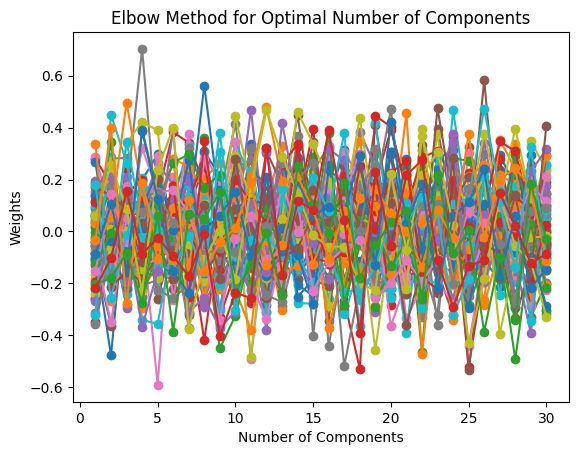

In [67]:
from sklearn.random_projection import GaussianRandomProjection

# Initialize Random Projection
grp = GaussianRandomProjection(n_components=30, random_state=RANDOM_SEED)

# Fit Random Projection on the scaled training data
grp.fit(X_train_scaled)

# Get weights
weights = grp.components_

# Plot weights to visualize the explained variance
plt.plot(range(1, len(weights)+1), weights, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Weights')
plt.title('Elbow Method for Optimal Number of Components')
plt.show()

## 2.4 t-SNE

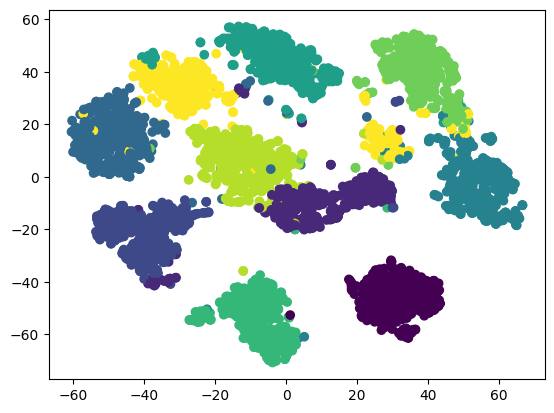

In [68]:
from sklearn.manifold import TSNE

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# Fit TSNE on the scaled training data
X_train_tsne = tsne.fit_transform(X_train_scaled)

# Plot TSNE
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')

